In [1]:
import sys
!{sys.executable} -m pip install -r requirements_all.txt

     ---------------------------------------- 0.0/90.6 kB ? eta -:--:--
     ------------ ------------------------- 30.7/90.6 kB 660.6 kB/s eta 0:00:01
     ---------------------------------------- 90.6/90.6 kB 1.3 MB/s eta 0:00:00
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_inspection-0.4.2-py3-none-any.whl.metadata (2.6 kB)
   ---------------------------------------- 0.0/103.1 kB ? eta -:--:--
   ---------------------------------------- 103.1/103.1 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/463.6 kB ? eta -:--:--
   --------------------------------- ------ 389.1/463.6 kB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 463.6/463.6 kB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB 8.9 MB/s eta 0:00:01
   ----------------- 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning - REGRESSION
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensemble models
try:
    import xgboost as xgb
    print("✓ XGBoost available")
except:
    print("⚠ XGBoost not installed. Run: pip install xgboost")

try:
    import lightgbm as lgb
    print("✓ LightGBM available")
except:
    print("⚠ LightGBM not installed. Run: pip install lightgbm")

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("\n✓ Đã import thư viện thành công!")

✓ XGBoost available
✓ LightGBM available

✓ Đã import thư viện thành công!


In [31]:
# Load data
df = pd.read_csv('data/XRPUSDT20182024new.csv')
df_pred = pd.read_csv('XRPUSDT_2025_Q1.csv')

print("=" * 80)
print("THÔNG TIN DỮ LIỆU GỐC")
print("=" * 80)
print(f"Số dòng: {len(df)}")
print(f"Các cột: {list(df.columns)}")
print(f"\n5 dòng đầu:")
display(df.head())

# Tiền xử lý
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Change %'], errors='ignore', inplace=True)
df = df.sort_values('Date').reset_index(drop=True)

df_pred['Date'] = pd.to_datetime(df_pred['Date'])
df_pred.drop(columns=['Change %'], errors='ignore', inplace=True)
df_pred = df_pred.sort_values('Date').reset_index(drop=True)

print(f"\n✓ Khoảng thời gian: {df['Date'].min().date()} đến {df['Date'].max().date()}")
print(f"✓ Tổng số ngày: {(df['Date'].max() - df['Date'].min()).days} ngày")

THÔNG TIN DỮ LIỆU GỐC
Số dòng: 2192
Các cột: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol', 'Change %']

5 dòng đầu:


,Date,Price,Open,High,Low,Vol,Change %
0,5/26/2024,0.5341,0.5416,0.5418,0.5328,178450000.0,-1.39%
1,5/25/2024,0.5416,0.5359,0.5425,0.5334,246380000.0,1.09%
2,5/24/2024,0.5358,0.5288,0.5372,0.5169,513880000.0,1.33%
3,5/23/2024,0.5288,0.5269,0.5456,0.5091,948100000.0,0.38%
4,5/22/2024,0.5268,0.5372,0.5382,0.5236,509460000.0,-1.94%



✓ Khoảng thời gian: 2018-05-26 đến 2024-05-26
✓ Tổng số ngày: 2192 ngày


## 2. Feature Engineering Nâng cao

In [32]:
def create_advanced_features(df):
    """
    Tạo features phù hợp cho dataset nhỏ (90 dòng)
    """
    print("\n" + "=" * 80)
    print("FEATURE ENGINEERING - OPTIMIZED FOR SMALL DATASET")
    print("=" * 80)
    
    df_feat = df.copy()
    
    # ==================== PRICE-BASED FEATURES ====================
    print("\n1. Price-based features...")
    
    # Returns (chỉ dùng window ngắn)
    df_feat['Return_1d'] = df_feat['Price'].pct_change(1) * 100
    df_feat['Return_3d'] = df_feat['Price'].pct_change(3) * 100
    df_feat['Return_7d'] = df_feat['Price'].pct_change(7) * 100
    
    # Price ranges
    df_feat['HL_Range'] = df_feat['High'] - df_feat['Low']
    df_feat['HL_Range_Pct'] = (df_feat['HL_Range'] / df_feat['Low']) * 100
    df_feat['OC_Range'] = abs(df_feat['Open'] - df_feat['Price'])
    df_feat['OC_Range_Pct'] = (df_feat['OC_Range'] / df_feat['Open']) * 100
    
    # Price position
    df_feat['Price_Position'] = (df_feat['Price'] - df_feat['Low']) / df_feat['HL_Range']
    
    print("   ✓ Returns (1d, 3d, 7d)")
    print("   ✓ Price ranges and positions")
    
    # ==================== MOVING AVERAGES ====================
    print("\n2. Moving averages...")
    
    # SMA - CHỈ DÙNG WINDOW NGẮN (tối đa 30 cho 90 dòng)
    for period in [5, 7, 10, 14, 20, 30]:
        df_feat[f'SMA_{period}'] = df_feat['Price'].rolling(window=period).mean()
        df_feat[f'Price_to_SMA_{period}'] = (df_feat['Price'] / df_feat[f'SMA_{period}'] - 1) * 100
    
    # EMA
    for period in [5, 10, 20]:
        df_feat[f'EMA_{period}'] = df_feat['Price'].ewm(span=period, adjust=False).mean()
        df_feat[f'Price_to_EMA_{period}'] = (df_feat['Price'] / df_feat[f'EMA_{period}'] - 1) * 100
    
    print("   ✓ SMA (5, 7, 10, 14, 20, 30)")
    print("   ✓ EMA (5, 10, 20)")
    
    # ==================== BOLLINGER BANDS ====================
    print("\n3. Bollinger Bands...")
    
    for period in [10, 20]:
        bb_middle = df_feat['Price'].rolling(window=period).mean()
        bb_std = df_feat['Price'].rolling(window=period).std()
        
        df_feat[f'BB_Upper_{period}'] = bb_middle + (2 * bb_std)
        df_feat[f'BB_Lower_{period}'] = bb_middle - (2 * bb_std)
        df_feat[f'BB_Width_{period}'] = df_feat[f'BB_Upper_{period}'] - df_feat[f'BB_Lower_{period}']
        df_feat[f'BB_Position_{period}'] = (df_feat['Price'] - df_feat[f'BB_Lower_{period}']) / df_feat[f'BB_Width_{period}']
    
    print("   ✓ BB (10, 20)")
    
    # ==================== MOMENTUM INDICATORS ====================
    print("\n4. Momentum indicators...")
    
    # RSI
    for period in [7, 14]:
        delta = df_feat['Price'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        df_feat[f'RSI_{period}'] = 100 - (100 / (1 + rs))
    
    # Stochastic
    for period in [14]:
        low_min = df_feat['Low'].rolling(window=period).min()
        high_max = df_feat['High'].rolling(window=period).max()
        df_feat[f'Stoch_{period}'] = 100 * (df_feat['Price'] - low_min) / (high_max - low_min)
    
    # ROC
    for period in [5, 10]:
        df_feat[f'ROC_{period}'] = ((df_feat['Price'] - df_feat['Price'].shift(period)) / df_feat['Price'].shift(period)) * 100
    
    print("   ✓ RSI (7, 14)")
    print("   ✓ Stochastic (14)")
    print("   ✓ ROC (5, 10)")
    
    # ==================== MACD ====================
    print("\n5. MACD...")
    
    ema_12 = df_feat['Price'].ewm(span=12, adjust=False).mean()
    ema_26 = df_feat['Price'].ewm(span=26, adjust=False).mean()
    df_feat['MACD'] = ema_12 - ema_26
    df_feat['MACD_Signal'] = df_feat['MACD'].ewm(span=9, adjust=False).mean()
    df_feat['MACD_Histogram'] = df_feat['MACD'] - df_feat['MACD_Signal']
    
    print("   ✓ MACD, Signal, Histogram")
    
    # ==================== VOLATILITY ====================
    print("\n6. Volatility indicators...")
    
    for period in [5, 10, 20]:
        df_feat[f'Volatility_{period}'] = df_feat['Return_1d'].rolling(window=period).std()
        df_feat[f'ATR_{period}'] = df_feat['HL_Range'].rolling(window=period).mean()
    
    print("   ✓ Volatility (5, 10, 20)")
    print("   ✓ ATR (5, 10, 20)")
    
    # ==================== VOLUME FEATURES ====================
    print("\n7. Volume features...")
    
    df_feat['Vol_Change'] = df_feat['Vol'].pct_change() * 100
    
    for period in [5, 10, 20]:
        df_feat[f'Vol_SMA_{period}'] = df_feat['Vol'].rolling(window=period).mean()
        df_feat[f'Vol_Ratio_{period}'] = df_feat['Vol'] / df_feat[f'Vol_SMA_{period}']
    
    df_feat['Vol_Price_Corr_20'] = df_feat['Vol'].rolling(window=20).corr(df_feat['Price'])
    
    print("   ✓ Volume changes and ratios")
    print("   ✓ Volume-Price correlation")
    
    # ==================== LAG FEATURES ====================
    print("\n8. Lag features...")
    
    for lag in [1, 2, 3, 5, 7]:
        df_feat[f'Price_Lag_{lag}'] = df_feat['Price'].shift(lag)
        df_feat[f'Return_Lag_{lag}'] = df_feat['Return_1d'].shift(lag)
        df_feat[f'Vol_Lag_{lag}'] = df_feat['Vol'].shift(lag)
    
    print("   ✓ Price, Return, Volume lags (1, 2, 3, 5, 7)")
    
    # ==================== STATISTICAL FEATURES ====================
    print("\n9. Statistical features...")
    
    for period in [7, 14, 30]:
        df_feat[f'Price_Mean_{period}'] = df_feat['Price'].rolling(window=period).mean()
        df_feat[f'Price_Std_{period}'] = df_feat['Price'].rolling(window=period).std()
        df_feat[f'Price_Min_{period}'] = df_feat['Price'].rolling(window=period).min()
        df_feat[f'Price_Max_{period}'] = df_feat['Price'].rolling(window=period).max()
        df_feat[f'Price_Range_{period}'] = df_feat[f'Price_Max_{period}'] - df_feat[f'Price_Min_{period}']
    
    print("   ✓ Rolling statistics (mean, std, min, max, range)")
    
    # ==================== TIME FEATURES ====================
    print("\n10. Time-based features...")
    
    df_feat['Day_of_Week'] = df_feat['Date'].dt.dayofweek
    df_feat['Day_of_Month'] = df_feat['Date'].dt.day
    df_feat['Month'] = df_feat['Date'].dt.month
    df_feat['Quarter'] = df_feat['Date'].dt.quarter
    df_feat['Year'] = df_feat['Date'].dt.year
    
    print("   ✓ Day of week, month, quarter, year")
    
    # ==================== TARGET VARIABLE ====================
    print("\n11. Creating target variable...")
    
    df_feat['Target_Price'] = df_feat['Price'].shift(-1)
    df_feat['Target_Return'] = ((df_feat['Target_Price'] - df_feat['Price']) / df_feat['Price']) * 100
    
    print("   ✓ Target_Price: Next day price (REGRESSION)")
    print("   ✓ Target_Return: % return")
    
    print("\n" + "=" * 80)
    print(f"✓ HOÀN THÀNH! Tổng số features: {len(df_feat.columns)}")
    print("=" * 80)
    
    return df_feat

# Tạo features
df_features = create_advanced_features(df)
df_pred_features = create_advanced_features(df_pred)


FEATURE ENGINEERING - OPTIMIZED FOR SMALL DATASET

1. Price-based features...
   ✓ Returns (1d, 3d, 7d)
   ✓ Price ranges and positions

2. Moving averages...
   ✓ SMA (5, 7, 10, 14, 20, 30)
   ✓ EMA (5, 10, 20)

3. Bollinger Bands...
   ✓ BB (10, 20)

4. Momentum indicators...
   ✓ RSI (7, 14)
   ✓ Stochastic (14)
   ✓ ROC (5, 10)

5. MACD...
   ✓ MACD, Signal, Histogram

6. Volatility indicators...
   ✓ Volatility (5, 10, 20)
   ✓ ATR (5, 10, 20)

7. Volume features...
   ✓ Volume changes and ratios
   ✓ Volume-Price correlation

8. Lag features...
   ✓ Price, Return, Volume lags (1, 2, 3, 5, 7)

9. Statistical features...
   ✓ Rolling statistics (mean, std, min, max, range)

10. Time-based features...
   ✓ Day of week, month, quarter, year

11. Creating target variable...
   ✓ Target_Price: Next day price (REGRESSION)
   ✓ Target_Return: % return

✓ HOÀN THÀNH! Tổng số features: 99

FEATURE ENGINEERING - OPTIMIZED FOR SMALL DATASET

1. Price-based features...
   ✓ Returns (1d, 3d, 

## 3. Chuẩn bị Dữ liệu cho Training (TIME-BASED SPLIT)

In [38]:
print("\n" + "=" * 80)
print("CHUẨN BỊ DỮ LIỆU CHO TRAINING - TIME-BASED SPLIT")
print("=" * 80)

# Loại bỏ NaN
df_clean = df_features.dropna()
df_pred_clean = df_pred_features.dropna()
print(f"\n1. Số dòng sau khi loại bỏ NaN: {len(df_clean)} (từ {len(df_features)})")

# Chọn features (loại bỏ Date, Target columns, và các cột gốc không cần)
exclude_cols = ['Date', 'Target_Price', 'Target_Return']
feature_columns = [col for col in df_clean.columns if col not in exclude_cols]

print(f"\n2. Tổng số features: {len(feature_columns)}")

# Prepare X and y - DỰ ĐOÁN GIÁ
X = df_clean[feature_columns]
y = df_clean['Target_Price']  # REGRESSION TARGET

df_pred_X = df_pred_clean[feature_columns]
df_pred_y = df_pred_clean['Target_Price']


print(f"\n3. Shape of X: {X.shape}")
print(f"   Shape of y: {y.shape}")

# Target statistics
print(f"\n4. Target Price statistics:")
print(f"   Min:  ${y.min():.4f}")
print(f"   Max:  ${y.max():.4f}")
print(f"   Mean: ${y.mean():.4f}")
print(f"   Std:  ${y.std():.4f}")

# ==================== TIME-BASED SPLIT ====================
# QUAN TRỌNG: Không shuffle để giữ tính thời gian!
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Get date ranges for train and test
train_dates = df_clean.loc[X_train.index, 'Date']
test_dates = df_clean.loc[X_test.index, 'Date']

# df_pred_dates = df_pred_clean.loc[X_train.index, 'Date']



print(f"\n5. ⏰ TIME-BASED SPLIT (80-20):")
print(f"   {'='*60}")
print(f"   📊 TRAIN SET:")
print(f"      - Samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"      - Period:  {train_dates.min().date()} → {train_dates.max().date()}")
print(f"      - Days:    {(train_dates.max() - train_dates.min()).days} days")
print(f"")
print(f"   🎯 TEST SET:")
print(f"      - Samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"      - Period:  {test_dates.min().date()} → {test_dates.max().date()}")
print(f"      - Days:    {(test_dates.max() - test_dates.min()).days} days")
print(f"   {'='*60}")

# Scaling
scaler = RobustScaler()  # Robust to outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(f"\n6. ✓ Đã scale features với RobustScaler")

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("\n" + "=" * 80)
print("✓ SẴN SÀNG CHO TRAINING!")
print("=" * 80)


CHUẨN BỊ DỮ LIỆU CHO TRAINING - TIME-BASED SPLIT

1. Số dòng sau khi loại bỏ NaN: 2162 (từ 2192)

2. Tổng số features: 96

3. Shape of X: (2162, 96)
   Shape of y: (2162,)

4. Target Price statistics:
   Min:  $0.1360
   Max:  $1.8363
   Mean: $0.4893
   Std:  $0.2659

5. ⏰ TIME-BASED SPLIT (80-20):
   📊 TRAIN SET:
      - Samples: 1729 (80.0%)
      - Period:  2018-06-24 → 2023-03-18
      - Days:    1728 days

   🎯 TEST SET:
      - Samples: 433 (20.0%)
      - Period:  2023-03-19 → 2024-05-25
      - Days:    433 days

6. ✓ Đã scale features với RobustScaler

✓ SẴN SÀNG CHO TRAINING!


## 4. Training Ensemble Models - REGRESSION

In [37]:
print("\n" + "=" * 80)
print("TRAINING ENSEMBLE MODELS - REGRESSION")
print("=" * 80)

# Dictionary to store models and results
models = {}
results = {}

# ==================== 1. RANDOM FOREST REGRESSOR ====================
print("\n1. Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model
print("   ✓ Done!")

# ==================== 2. XGBOOST REGRESSOR ====================
print("\n2. Training XGBoost Regressor...")
try:
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train, verbose=False)
    models['XGBoost'] = xgb_model
    print("   ✓ Done!")
except:
    print("   ⚠ XGBoost not available")

# ==================== 3. LIGHTGBM REGRESSOR ====================
print("\n3. Training LightGBM Regressor...")
try:
    lgb_model = lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train_scaled, y_train)
    models['LightGBM'] = lgb_model
    print("   ✓ Done!")
except:
    print("   ⚠ LightGBM not available")

# ==================== 4. ADABOOST REGRESSOR ====================
print("\n4. Training AdaBoost Regressor...")
ada_model = AdaBoostRegressor(
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
ada_model.fit(X_train_scaled, y_train)
models['AdaBoost'] = ada_model
print("   ✓ Done!")

# ==================== 5. VOTING REGRESSOR ====================
print("\n5. Creating Voting Regressor...")
estimators = [(name, model) for name, model in models.items()]
voting_model = VotingRegressor(
    estimators=estimators,
    n_jobs=-1
)
voting_model.fit(X_train_scaled, y_train)
models['Voting Regressor'] = voting_model
print("   ✓ Done!")

print("\n" + "=" * 80)
print(f"✓ HOÀN THÀNH TRAINING {len(models)} MODELS!")
print("=" * 80)


TRAINING ENSEMBLE MODELS - REGRESSION

1. Training Random Forest Regressor...
   ✓ Done!

2. Training XGBoost Regressor...
   ✓ Done!

3. Training LightGBM Regressor...
   ✓ Done!

4. Training AdaBoost Regressor...
   ✓ Done!

5. Creating Voting Regressor...
   ✓ Done!

✓ HOÀN THÀNH TRAINING 5 MODELS!


## 5. Đánh giá Models - REGRESSION METRICS

In [41]:
print("\n" + "=" * 80)
print("ĐÁNH GIÁ MODELS - REGRESSION METRICS")
print("=" * 80)

# Evaluate all models
for name, model in models.items():
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Regression Metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # MAPE (Mean Absolute Percentage Error)
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    
    results[name] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mape': test_mape,
        'predictions': y_pred_test
    }

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train MAE': [results[m]['train_mae'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Train RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test MAPE (%)': [results[m]['test_mape'] for m in results.keys()]
})

# Sort by Test MAE (lower is better)
results_df = results_df.sort_values('Test MAE', ascending=True).reset_index(drop=True)

print("\n" + "-" * 80)
print("BẢNG KẾT QUẢ")
print("-" * 80)
display(results_df.style.format({
    'Train MAE': '${:.4f}',
    'Test MAE': '${:.4f}',
    'Train RMSE': '${:.4f}',
    'Test RMSE': '${:.4f}',
    'Train R²': '{:.4f}',
    'Test R²': '{:.4f}',
    'Test MAPE (%)': '{:.2f}%'
}).background_gradient(subset=['Test MAE', 'Test RMSE'], cmap='RdYlGn_r').background_gradient(subset=['Test R²'], cmap='RdYlGn'))

# Best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test MAE:  ${results_df.iloc[0]['Test MAE']:.4f}")
print(f"   Test RMSE: ${results_df.iloc[0]['Test RMSE']:.4f}")
print(f"   Test R²:   {results_df.iloc[0]['Test R²']:.4f}")
print(f"   Test MAPE: {results_df.iloc[0]['Test MAPE (%)']:.2f}%")

print("\n📊 Giải thích metrics:")
print("   - MAE (Mean Absolute Error): Sai số tuyệt đối trung bình (càng thấp càng tốt)")
print("   - RMSE (Root Mean Squared Error): Căn bậc hai của sai số bình phương trung bình (càng thấp càng tốt)")
print("   - R² (R-squared): Hệ số xác định (càng gần 1 càng tốt, max=1)")
print("   - MAPE (Mean Absolute Percentage Error): Sai số phần trăm tuyệt đối trung bình (càng thấp càng tốt)")


ĐÁNH GIÁ MODELS - REGRESSION METRICS

--------------------------------------------------------------------------------
BẢNG KẾT QUẢ
--------------------------------------------------------------------------------


,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²,Test MAPE (%)
0,Random Forest,$0.0133,$0.0175,$0.0279,$0.0283,0.9909,0.8562,3.09%
1,LightGBM,$0.0095,$0.0189,$0.0161,$0.0311,0.9970,0.8254,3.31%
2,Voting Regressor,$0.0121,$0.0195,$0.0188,$0.0314,0.9959,0.8228,3.41%
3,XGBoost,$0.0020,$0.0222,$0.0027,$0.0352,0.9999,0.7763,3.87%
4,AdaBoost,$0.0281,$0.0287,$0.0388,$0.0420,0.9824,0.6819,4.97%



🏆 BEST MODEL: Random Forest
   Test MAE:  $0.0175
   Test RMSE: $0.0283
   Test R²:   0.8562
   Test MAPE: 3.09%

📊 Giải thích metrics:
   - MAE (Mean Absolute Error): Sai số tuyệt đối trung bình (càng thấp càng tốt)
   - RMSE (Root Mean Squared Error): Căn bậc hai của sai số bình phương trung bình (càng thấp càng tốt)
   - R² (R-squared): Hệ số xác định (càng gần 1 càng tốt, max=1)
   - MAPE (Mean Absolute Percentage Error): Sai số phần trăm tuyệt đối trung bình (càng thấp càng tốt)


## 6. 📊 ACTUAL vs PREDICTED PRICE (Test Set)


ACTUAL vs PREDICTED PRICE - Random Forest

Test Period: 2023-03-19 to 2024-05-25
Total predictions: 433

Sample predictions:


,Date,Actual_Price,Predicted_Price,Error,Error_Pct
0,2023-03-19 00:00:00,$0.3732,$0.3812,$-0.0080,-2.15%
1,2023-03-20 00:00:00,$0.4683,$0.3740,$0.0943,20.13%
2,2023-03-21 00:00:00,$0.4211,$0.4375,$-0.0164,-3.89%
3,2023-03-22 00:00:00,$0.4440,$0.4308,$0.0132,2.98%
4,2023-03-23 00:00:00,$0.4256,$0.4432,$-0.0176,-4.14%
5,2023-03-24 00:00:00,$0.4432,$0.4321,$0.0111,2.51%
6,2023-03-25 00:00:00,$0.4480,$0.4424,$0.0056,1.24%
7,2023-03-26 00:00:00,$0.4793,$0.4541,$0.0252,5.26%
8,2023-03-27 00:00:00,$0.5144,$0.4796,$0.0348,6.77%
9,2023-03-28 00:00:00,$0.5427,$0.5126,$0.0301,5.54%


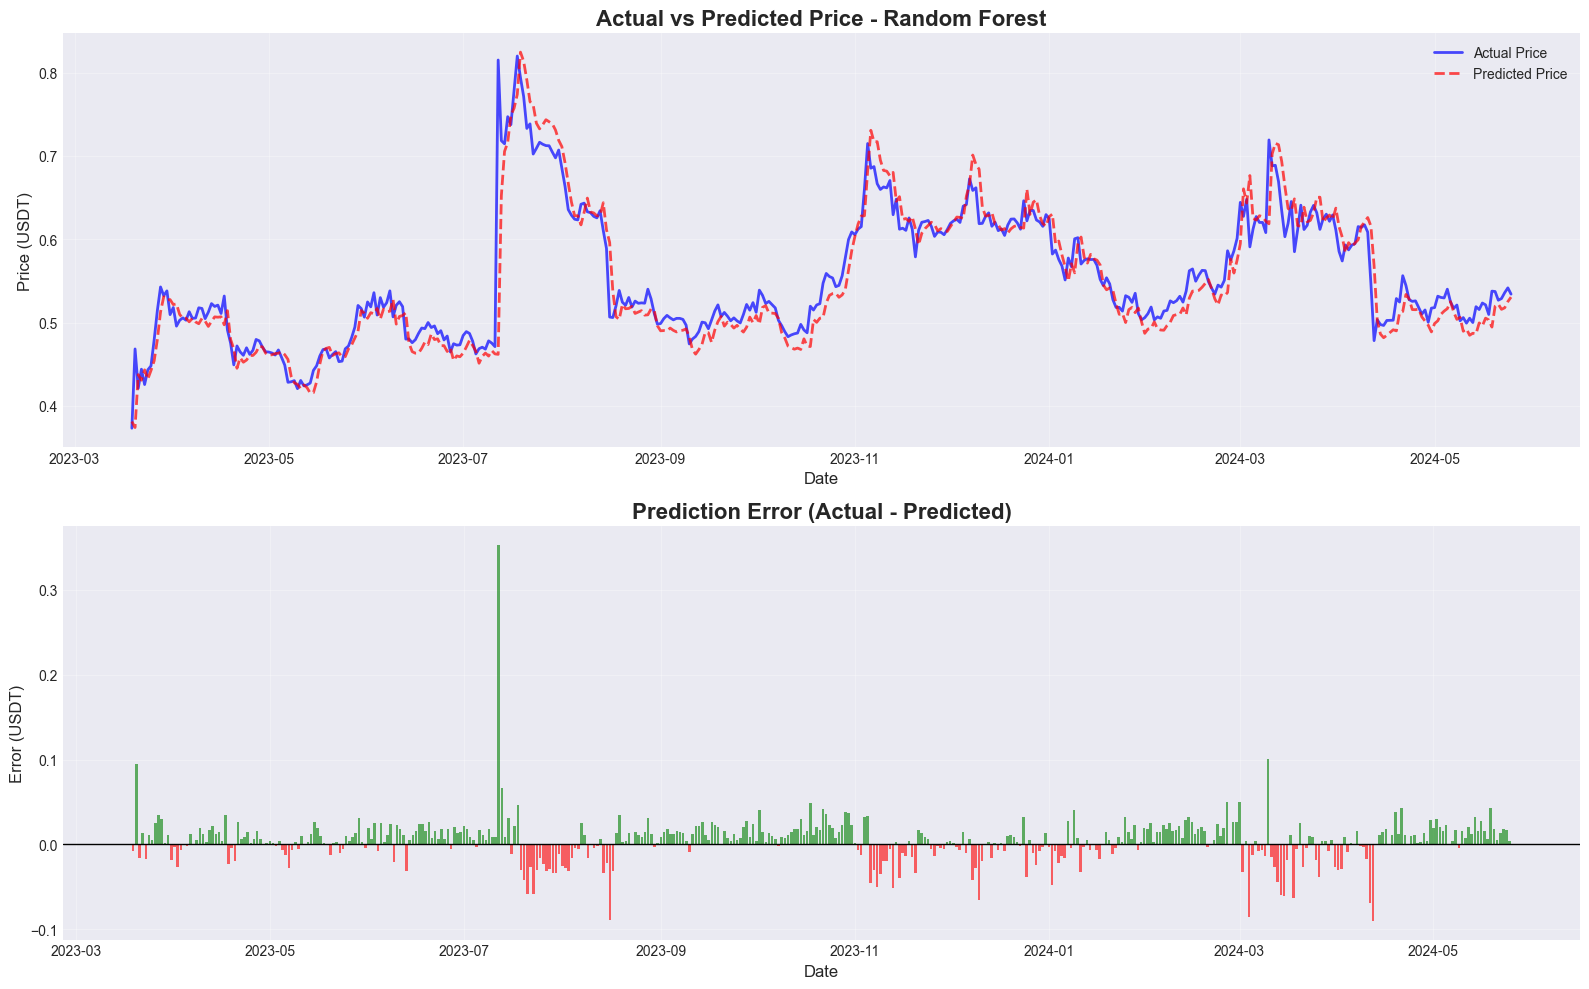


ERROR STATISTICS
Mean Error:        $0.0045
Mean Abs Error:    $0.0175
Max Error:         $0.3532
Min Error:         $-0.0900
Std Error:         $0.0279

Mean Error %:      0.90%
Mean Abs Error %:  3.09%


In [42]:
print("\n" + "=" * 80)
print(f"ACTUAL vs PREDICTED PRICE - {best_model_name}")
print("=" * 80)

# Get best model predictions
best_predictions = results[best_model_name]['predictions']

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Date': test_dates.values,
    'Actual_Price': y_test.values,
    'Predicted_Price': best_predictions,
    'Error': y_test.values - best_predictions,
    'Error_Pct': ((y_test.values - best_predictions) / y_test.values) * 100
})

print(f"\nTest Period: {test_dates.min().date()} to {test_dates.max().date()}")
print(f"Total predictions: {len(comparison_df)}")
print(f"\nSample predictions:")
display(comparison_df.head(10).style.format({
    'Actual_Price': '${:.4f}',
    'Predicted_Price': '${:.4f}',
    'Error': '${:.4f}',
    'Error_Pct': '{:.2f}%'
}))

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Actual vs Predicted Price
ax1 = axes[0]
ax1.plot(comparison_df['Date'], comparison_df['Actual_Price'], 
         label='Actual Price', linewidth=2, color='blue', alpha=0.7)
ax1.plot(comparison_df['Date'], comparison_df['Predicted_Price'], 
         label='Predicted Price', linewidth=2, color='red', alpha=0.7, linestyle='--')
ax1.set_title(f'Actual vs Predicted Price - {best_model_name}', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price (USDT)', fontsize=12)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Prediction Error
ax2 = axes[1]
colors = ['green' if e > 0 else 'red' for e in comparison_df['Error']]
ax2.bar(comparison_df['Date'], comparison_df['Error'], color=colors, alpha=0.6)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Prediction Error (Actual - Predicted)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Error (USDT)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error statistics
print("\n" + "=" * 80)
print("ERROR STATISTICS")
print("=" * 80)
print(f"Mean Error:        ${comparison_df['Error'].mean():.4f}")
print(f"Mean Abs Error:    ${comparison_df['Error'].abs().mean():.4f}")
print(f"Max Error:         ${comparison_df['Error'].max():.4f}")
print(f"Min Error:         ${comparison_df['Error'].min():.4f}")
print(f"Std Error:         ${comparison_df['Error'].std():.4f}")
print(f"\nMean Error %:      {comparison_df['Error_Pct'].mean():.2f}%")
print(f"Mean Abs Error %:  {comparison_df['Error_Pct'].abs().mean():.2f}%")

## 7. 📈 Feature Importance


TOP 20 IMPORTANT FEATURES - Random Forest


,Feature,Importance
0,Price,0.0931
25,EMA_5,0.0779
1,Open,0.0772
79,Price_Max_7,0.0702
3,Low,0.0672
2,High,0.0586
76,Price_Mean_7,0.0545
13,SMA_5,0.0525
61,Price_Lag_1,0.0472
15,SMA_7,0.0467


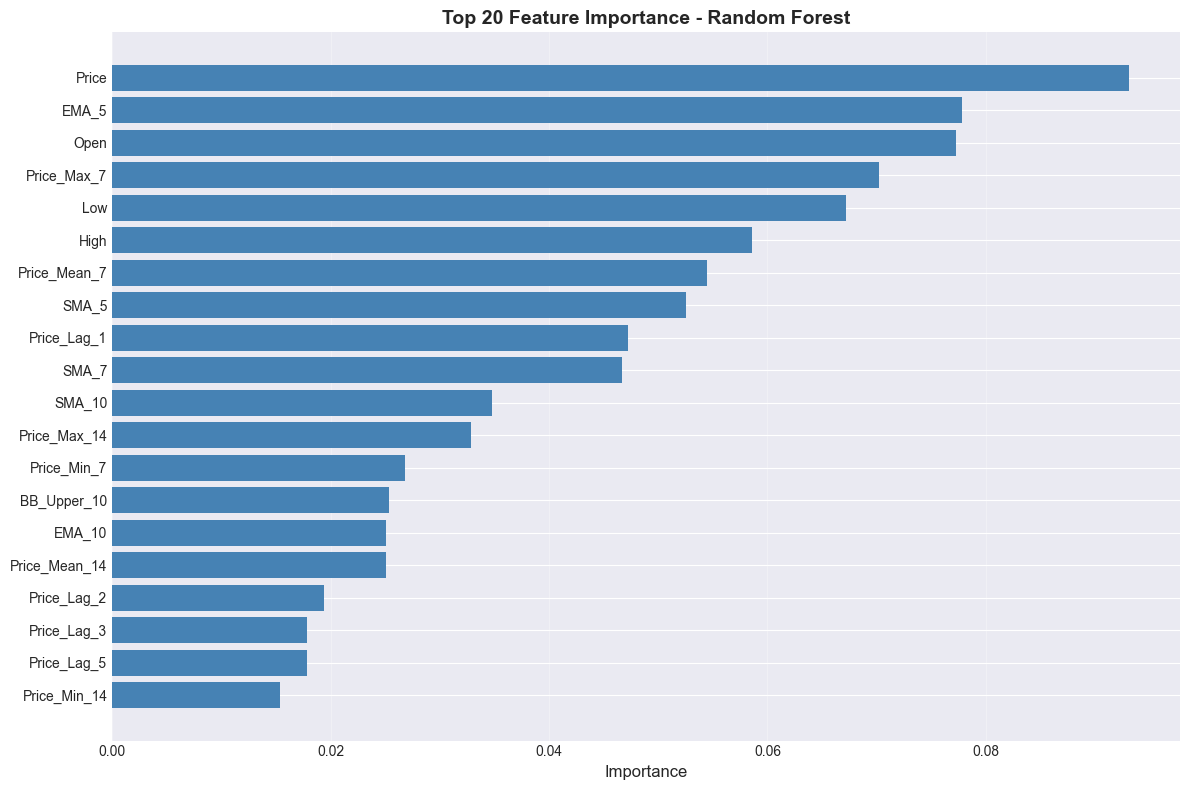

In [43]:
# Get feature importance from best model
best_model = models[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n" + "=" * 80)
    print(f"TOP 20 IMPORTANT FEATURES - {best_model_name}")
    print("=" * 80)
    display(feature_importance.head(20).style.format({'Importance': '{:.4f}'}).background_gradient(subset=['Importance'], cmap='YlGn'))
    
    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print(f"\n⚠ {best_model_name} không hỗ trợ feature importance")

## 8. 💾 Save Best Model

In [ ]:
# import pickle
# from datetime import datetime

# # Save best model
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# model_filename = f'xrp_regression_{best_model_name.replace(" ", "_")}_{timestamp}.pkl'
# scaler_filename = f'xrp_scaler_{timestamp}.pkl'

# # Save model
# with open(model_filename, 'wb') as f:
#     pickle.dump(models[best_model_name], f)

# # Save scaler
# with open(scaler_filename, 'wb') as f:
#     pickle.dump(scaler, f)

# print("\n" + "=" * 80)
# print("SAVED FILES")
# print("=" * 80)
# print(f"✓ Model saved: {model_filename}")
# print(f"✓ Scaler saved: {scaler_filename}")
# print(f"\n📝 Model info:")
# print(f"   - Model: {best_model_name}")
# print(f"   - Test MAE: ${results_df.iloc[0]['Test MAE']:.4f}")
# print(f"   - Test R²: {results_df.iloc[0]['Test R²']:.4f}")
# print(f"   - Features: {len(feature_columns)}")
# print(f"   - Training samples: {len(X_train)}")
# print(f"   - Test samples: {len(X_test)}")

## 9. 🔮 PREDICT GIÁ XRP cho Dữ Liệu Mới (XRPUSDT_2025_Q1)

In [44]:
print("\n" + "=" * 80)
print("CHUẨN BỊ DỮ LIỆU ĐỂ DỰ ĐOÁN")
print("=" * 80)

# Tạo features cho dữ liệu mới (đã được load trước đó)
df_pred_clean = df_features.dropna()

print(f"\n1. Số dòng sau khi loại bỏ NaN: {len(df_pred_clean)} (từ {len(df_features)})")

# Chọn features giống như train set
X_pred = df_pred_clean[feature_columns]
print(f"2. Shape của X_pred: {X_pred.shape}")

# Scale dữ liệu dự đoán với scaler đã train
X_pred_scaled = scaler.transform(X_pred)
X_pred_scaled = pd.DataFrame(X_pred_scaled, columns=feature_columns, index=X_pred.index)

print(f"3. ✓ Đã scale dữ liệu")

# Lấy ngày tương ứng
pred_dates = df_pred_clean.loc[X_pred.index, 'Date']
pred_prices = df_pred_clean.loc[X_pred.index, 'Price']

print(f"\n4. 📅 Khoảng thời gian dữ liệu mới:")
print(f"   - Từ: {pred_dates.min().date()}")
print(f"   - Đến: {pred_dates.max().date()}")
print(f"   - Tổng ngày: {len(X_pred)}")

print("\n" + "=" * 80)
print("✓ SẴN SÀNG ĐỂ DỰ ĐOÁN!")
print("=" * 80)



CHUẨN BỊ DỮ LIỆU ĐỂ DỰ ĐOÁN

1. Số dòng sau khi loại bỏ NaN: 2162 (từ 2192)
2. Shape của X_pred: (2162, 96)
3. ✓ Đã scale dữ liệu

4. 📅 Khoảng thời gian dữ liệu mới:
   - Từ: 2018-06-24
   - Đến: 2024-05-25
   - Tổng ngày: 2162

✓ SẴN SÀNG ĐỂ DỰ ĐOÁN!


In [45]:
print("\n" + "=" * 80)
print(f"DỰ ĐOÁN GIÁ XRP BẰNG {best_model_name}")
print("=" * 80)

# Dự đoán với best model
y_pred_new = best_model.predict(X_pred_scaled)

# Tạo dataframe kết quả dự đoán
prediction_results = pd.DataFrame({
    'Date': pred_dates.values,
    'Current_Price': pred_prices.values,
    'Predicted_Price': y_pred_new,
    'Price_Change': y_pred_new - pred_prices.values,
    'Price_Change_Pct': ((y_pred_new - pred_prices.values) / pred_prices.values) * 100
})

print(f"\n✓ Đã dự đoán {len(prediction_results)} ngày")
print(f"\n📊 Kết quả dự đoán (10 ngày đầu):")
display(prediction_results.head(10).style.format({
    'Current_Price': '${:.4f}',
    'Predicted_Price': '${:.4f}',
    'Price_Change': '${:.4f}',
    'Price_Change_Pct': '{:.2f}%'
}))

# Thống kê dự đoán
print("\n" + "=" * 80)
print("THỐNG KÊ DỰ ĐOÁN")
print("=" * 80)
print(f"Giá hiện tại trung bình:  ${pred_prices.mean():.4f}")
print(f"Giá dự đoán trung bình:   ${y_pred_new.mean():.4f}")
print(f"\nDự đoán giá sẽ tăng:      {(prediction_results['Price_Change_Pct'] > 0).sum()} ngày ({(prediction_results['Price_Change_Pct'] > 0).sum()/len(prediction_results)*100:.1f}%)")
print(f"Dự đoán giá sẽ giảm:      {(prediction_results['Price_Change_Pct'] < 0).sum()} ngày ({(prediction_results['Price_Change_Pct'] < 0).sum()/len(prediction_results)*100:.1f}%)")
print(f"\nThay đổi giá trung bình:  {prediction_results['Price_Change_Pct'].mean():.2f}%")
print(f"Max dự đoán tăng:         {prediction_results['Price_Change_Pct'].max():.2f}%")
print(f"Max dự đoán giảm:         {prediction_results['Price_Change_Pct'].min():.2f}%")



DỰ ĐOÁN GIÁ XRP BẰNG Random Forest

✓ Đã dự đoán 2162 ngày

📊 Kết quả dự đoán (10 ngày đầu):


,Date,Current_Price,Predicted_Price,Price_Change,Price_Change_Pct
0,2018-06-24 00:00:00,$0.4745,$0.4670,$-0.0075,-1.58%
1,2018-06-25 00:00:00,$0.4808,$0.4623,$-0.0185,-3.85%
2,2018-06-26 00:00:00,$0.4530,$0.4543,$0.0013,0.28%
3,2018-06-27 00:00:00,$0.4719,$0.4566,$-0.0153,-3.25%
4,2018-06-28 00:00:00,$0.4479,$0.4507,$0.0028,0.62%
5,2018-06-29 00:00:00,$0.4553,$0.4577,$0.0024,0.52%
6,2018-06-30 00:00:00,$0.4649,$0.4637,$-0.0012,-0.25%
7,2018-07-01 00:00:00,$0.4623,$0.4698,$0.0075,1.63%
8,2018-07-02 00:00:00,$0.4900,$0.4840,$-0.0060,-1.23%
9,2018-07-03 00:00:00,$0.4852,$0.4841,$-0.0011,-0.23%



THỐNG KÊ DỰ ĐOÁN
Giá hiện tại trung bình:  $0.4892
Giá dự đoán trung bình:   $0.4883

Dự đoán giá sẽ tăng:      1030 ngày (47.6%)
Dự đoán giá sẽ giảm:      1132 ngày (52.4%)

Thay đổi giá trung bình:  0.00%
Max dự đoán tăng:         38.67%
Max dự đoán giảm:         -19.98%



📈 BIỂU ĐỒ DỰ ĐOÁN GIÁ XRP 2025 Q1


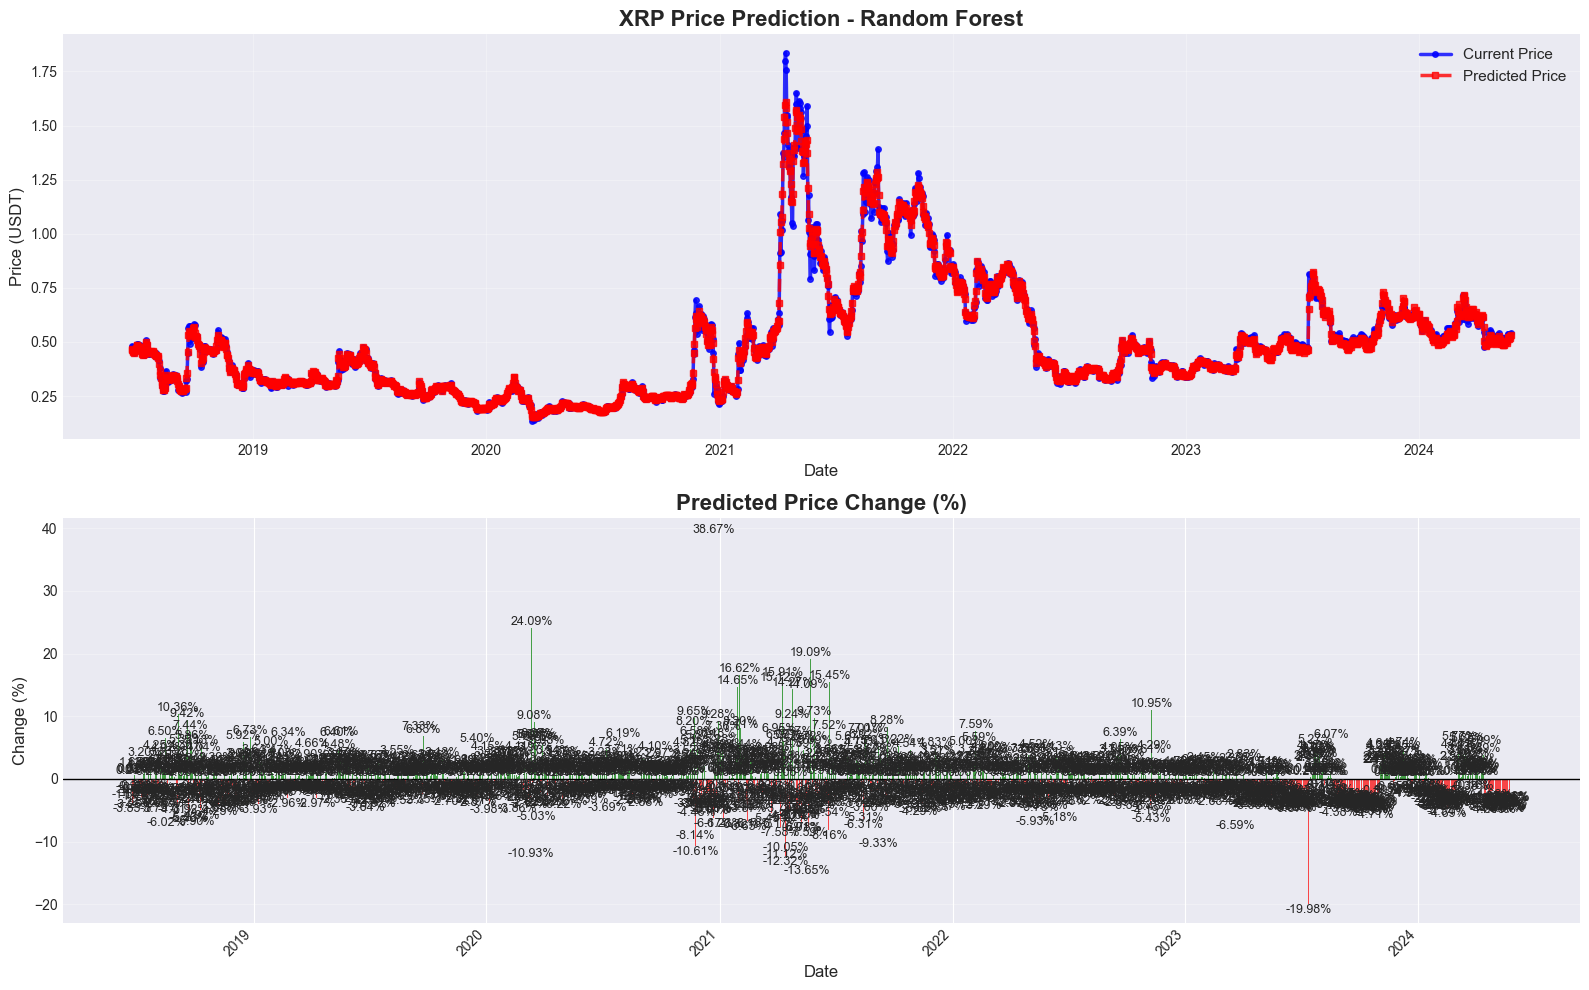


✓ Biểu đồ hiển thị thành công!


In [46]:
print("\n" + "=" * 80)
print("📈 BIỂU ĐỒ DỰ ĐOÁN GIÁ XRP 2025 Q1")
print("=" * 80)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Giá hiện tại vs Giá dự đoán
ax1 = axes[0]
ax1.plot(prediction_results['Date'], prediction_results['Current_Price'], 
         label='Current Price', linewidth=2.5, color='blue', alpha=0.8, marker='o', markersize=4)
ax1.plot(prediction_results['Date'], prediction_results['Predicted_Price'], 
         label='Predicted Price', linewidth=2.5, color='red', alpha=0.8, marker='s', markersize=4, linestyle='--')
ax1.fill_between(prediction_results['Date'], prediction_results['Current_Price'], 
                  prediction_results['Predicted_Price'], alpha=0.2, color='gray')
ax1.set_title(f'XRP Price Prediction - {best_model_name}', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price (USDT)', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Thay đổi giá dự đoán
ax2 = axes[1]
colors = ['green' if x > 0 else 'red' for x in prediction_results['Price_Change_Pct']]
bars = ax2.bar(prediction_results['Date'], prediction_results['Price_Change_Pct'], color=colors, alpha=0.7, width=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Predicted Price Change (%)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Change (%)', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Thêm giá trị trên cột
for bar, val in zip(bars, prediction_results['Price_Change_Pct']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✓ Biểu đồ hiển thị thành công!")


In [ ]:
# print("\n" + "=" * 80)
# print("💾 LƯU KẾT QUẢ DỰ ĐOÁN")
# print("=" * 80)

# # Lưu kết quả dự đoán
# results_filename = f'xrp_predictions_2025_Q1_{timestamp}.csv'
# prediction_results.to_csv(results_filename, index=False)

# print(f"\n✓ Kết quả dự đoán đã lưu: {results_filename}")
# print(f"  - Số dòng: {len(prediction_results)}")
# print(f"  - Khoảng thời gian: {prediction_results['Date'].min().date()} đến {prediction_results['Date'].max().date()}")

# # In thống kê tổng hợp
# print("\n" + "=" * 80)
# print("📋 TÓMLẠI KẾT QUẢ")
# print("=" * 80)
# print(f"\n🤖 Model được sử dụng: {best_model_name}")
# print(f"   - Test MAE:  ${results_df.iloc[0]['Test MAE']:.4f}")
# print(f"   - Test R²:   {results_df.iloc[0]['Test R²']:.4f}")
# print(f"   - Test MAPE: {results_df.iloc[0]['Test MAPE (%)']:.2f}%")

# print(f"\n📊 Dữ liệu dự đoán (XRPUSDT_2025_Q1):")
# print(f"   - Số ngày dự đoán: {len(prediction_results)}")
# print(f"   - Giá hiện tại TB:  ${prediction_results['Current_Price'].mean():.4f}")
# print(f"   - Giá dự đoán TB:   ${prediction_results['Predicted_Price'].mean():.4f}")
# print(f"   - Thay đổi TB:      {prediction_results['Price_Change_Pct'].mean():.2f}%")

# print(f"\n💡 Khuyến nghị:")
# print(f"   - Dự đoán tăng giá: {(prediction_results['Price_Change_Pct'] > 0).sum()} ngày")
# print(f"   - Dự đoán giảm giá: {(prediction_results['Price_Change_Pct'] < 0).sum()} ngày")
# print(f"   - Mức tăng cao nhất: +{prediction_results['Price_Change_Pct'].max():.2f}%")
# print(f"   - Mức giảm cao nhất: {prediction_results['Price_Change_Pct'].min():.2f}%")

# print("\n" + "=" * 80)
# print("✅ HOÀN THÀNH DỰ ĐOÁN!")
# print("=" * 80)
